utility_functions imports setup complete
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case


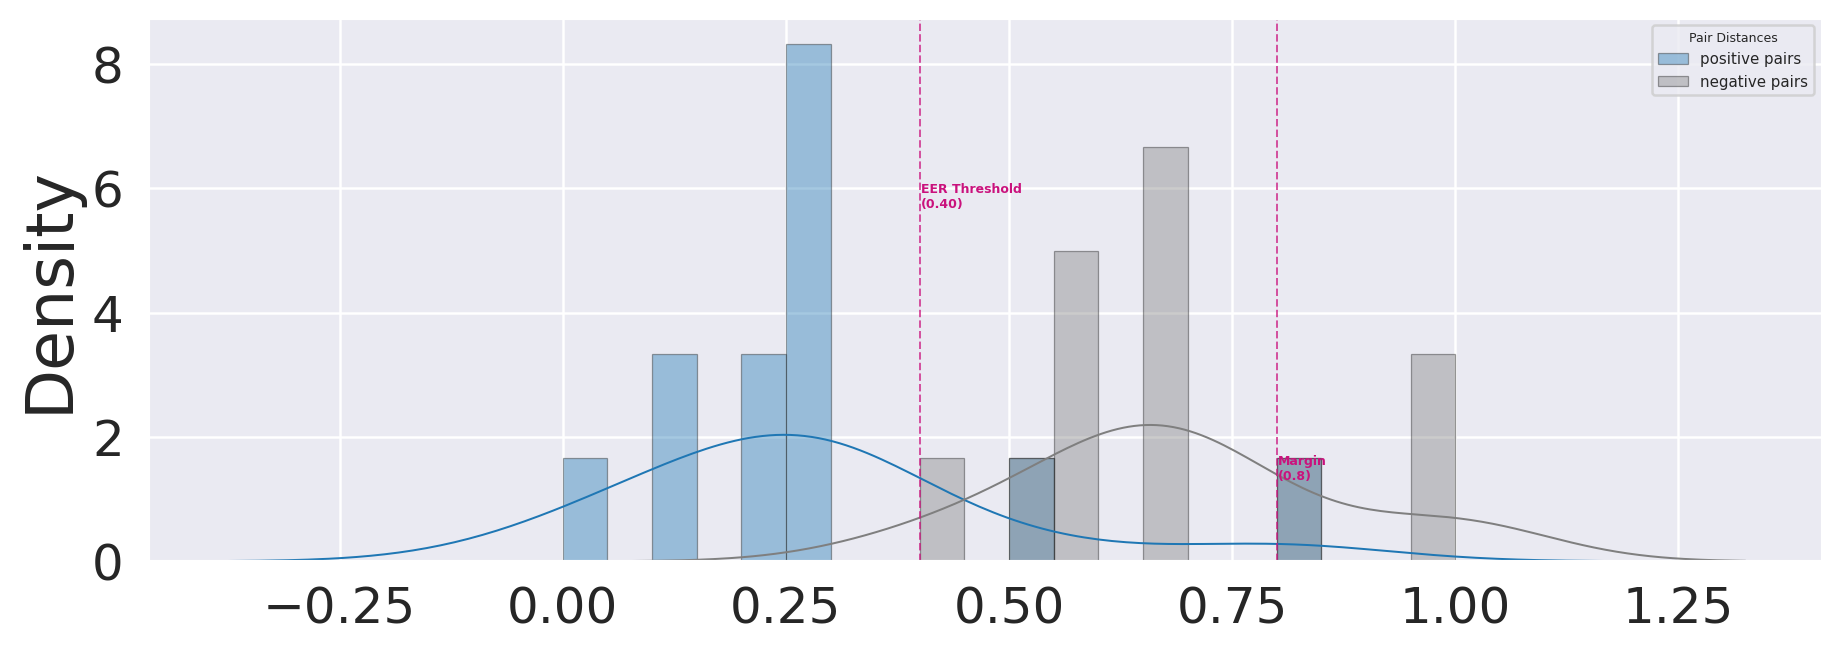

utility functions imported
Numpy Seed was set to: 567
Setup Complete


In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

CORES = -1
SEED = 567

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# !pip install --upgrade pip
# !pip install python-docx
# !pip install antropy

from sklearn.neighbors import NearestNeighbors
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
import math as math
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from dataclasses import asdict
from sklearn import svm
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import KFold

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import iqr
from scipy.stats import median_absolute_deviation
from scipy.stats import mode
from scipy.signal import find_peaks
from scipy.signal import peak_widths
# from scipy.special import entr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
get_new_scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler, "Normalizer": Normalizer, 
                       "MaxAbsScaler": MaxAbsScaler, "RobustScaler": RobustScaler, "PowerTransformer": PowerTransformer}
from sklearn.preprocessing import normalize
from sklearn.metrics import auc
# import antropy as ant
import time
# import docx

# Global utitlity functions are in separate notebook
# import utility_functions as uf
%run ./utility-functions.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

In [376]:
def plot_sys_err_distro(EER_distro_df, discription, save_file_name=None, boxplot_color="springgreen", sys_err=True):
    
    sns.set(err_distro_rc)
    y_col = "err"
    n_subject = len(EER_distro_df.columns)
    mean_col = EER_distro_df[y_col].mean()
    fig = plt.figure()
    ax = sns.boxplot(x="owner", y=y_col, data=EER_distro_df, color=boxplot_color)#, **utils_boxplot_style)
    
    # Select which box you want to change    
    mybox = ax.patches[4]

    if sys_err:
        
        # Change the appearance of that box
        mybox.set_facecolor('red')
        # mybox.set_edgecolor('black')
        # mybox.set_linewidth(3)
        
    else:
        mybox.set_facecolor('springgreen')
    
    ax.set_ylim((0, 1))
    sns.swarmplot(x="owner", y=y_col, data=EER_distro_df, color=".25")
    

    plt.plot(
        [-0.6, err_distro_rc["figure.figsize"][0] + 0.6],
        [mean_col, mean_col],
        linestyle="dashed",
        linewidth=2,
        color=MAGENTA,
        alpha=0.7,
    )
    plt.text(n_subject + 0.6, mean_col, f"mean", fontsize=err_distro_rc["ytick.labelsize"], color=MAGENTA)
    plt.text(
        n_subject + 0.6, mean_col - 0.04, f"{mean_col:.3f}", fontsize=err_distro_rc["ytick.labelsize"], color=MAGENTA
    )
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.title(discription)
    
    ax.set_xlabel("Owner id")
    ax.set_ylabel("err")
    
    plt.savefig(f'{save_file_name}', bbox_inches='tight')
    print(f"Overall mean: {mean_col:.4f}")
    

In [377]:
def make_sys_error_data(sys_err=True):
    
    
    data = pd.DataFrame(columns = ["owner_id", "err"])
    owner_lst = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    owner_id_lst = []
    cum_err_lst = []
    for owner_id in owner_lst:
        if sys_err:
            if owner_id != 4:
                err_arr = np.random.normal(0.05, 0.01 * random.randint(1, 10), len(owner_lst)-1)
            else:
                err_arr = np.random.normal(0.87, 0.01 * 10 , len(owner_lst)-1)
        else:
            err_arr = np.random.normal(0.05, 0.01 * random.randint(1, 10), len(owner_lst)-1)
        
        neg_data = -1 * err_arr[err_arr<0]
        # print(neg_data)
        # print( data['err'][owner].min())
        err_arr = err_arr[err_arr>0]
        err_arr = np.concatenate([err_arr, neg_data])
        cum_err_lst.append(err_arr)
        owner_id_lst.append(np.repeat(owner_id, len(err_arr)))
        
    cum_err_arr = np.concatenate(cum_err_lst)
    owner_id_arr = np.concatenate(owner_id_lst)
        # data['EER'][owner] = data['err'][owner].mean()
    err_distro_df = pd.DataFrame(data = {"owner": owner_id_arr, "err": cum_err_arr})
    
            
    
    return err_distro_df

In [378]:
np.random.normal(0.91, 0.02, 10)

array([0.90606626, 0.90512336, 0.90731471, 0.87571929, 0.89823948,
       0.91879002, 0.88595409, 0.93872986, 0.90581991, 0.9035896 ])

In [379]:
EER_distro_df = make_sys_error_data()

In [380]:
for i in range(10):
    print(EER_distro_df.loc[i])

owner    0.000000
err      0.100501
Name: 0, dtype: float64
owner    0.000000
err      0.104011
Name: 1, dtype: float64
owner    0.000000
err      0.081846
Name: 2, dtype: float64
owner    0.000000
err      0.022831
Name: 3, dtype: float64
owner    0.000000
err      0.182707
Name: 4, dtype: float64
owner    0.000000
err      0.118783
Name: 5, dtype: float64
owner    0.000000
err      0.055486
Name: 6, dtype: float64
owner    0.000000
err      0.010202
Name: 7, dtype: float64
owner    0.000000
err      0.057822
Name: 8, dtype: float64
owner    1.000000
err      0.050187
Name: 9, dtype: float64


In [381]:
EER_distro_df

,owner,err
0,0,0.100501
1,0,0.104011
2,0,0.081846
3,0,0.022831
4,0,0.182707
...,...,...
85,9,0.061098
86,9,0.106124
87,9,0.041998
88,9,0.018825


Overall mean: 0.1360


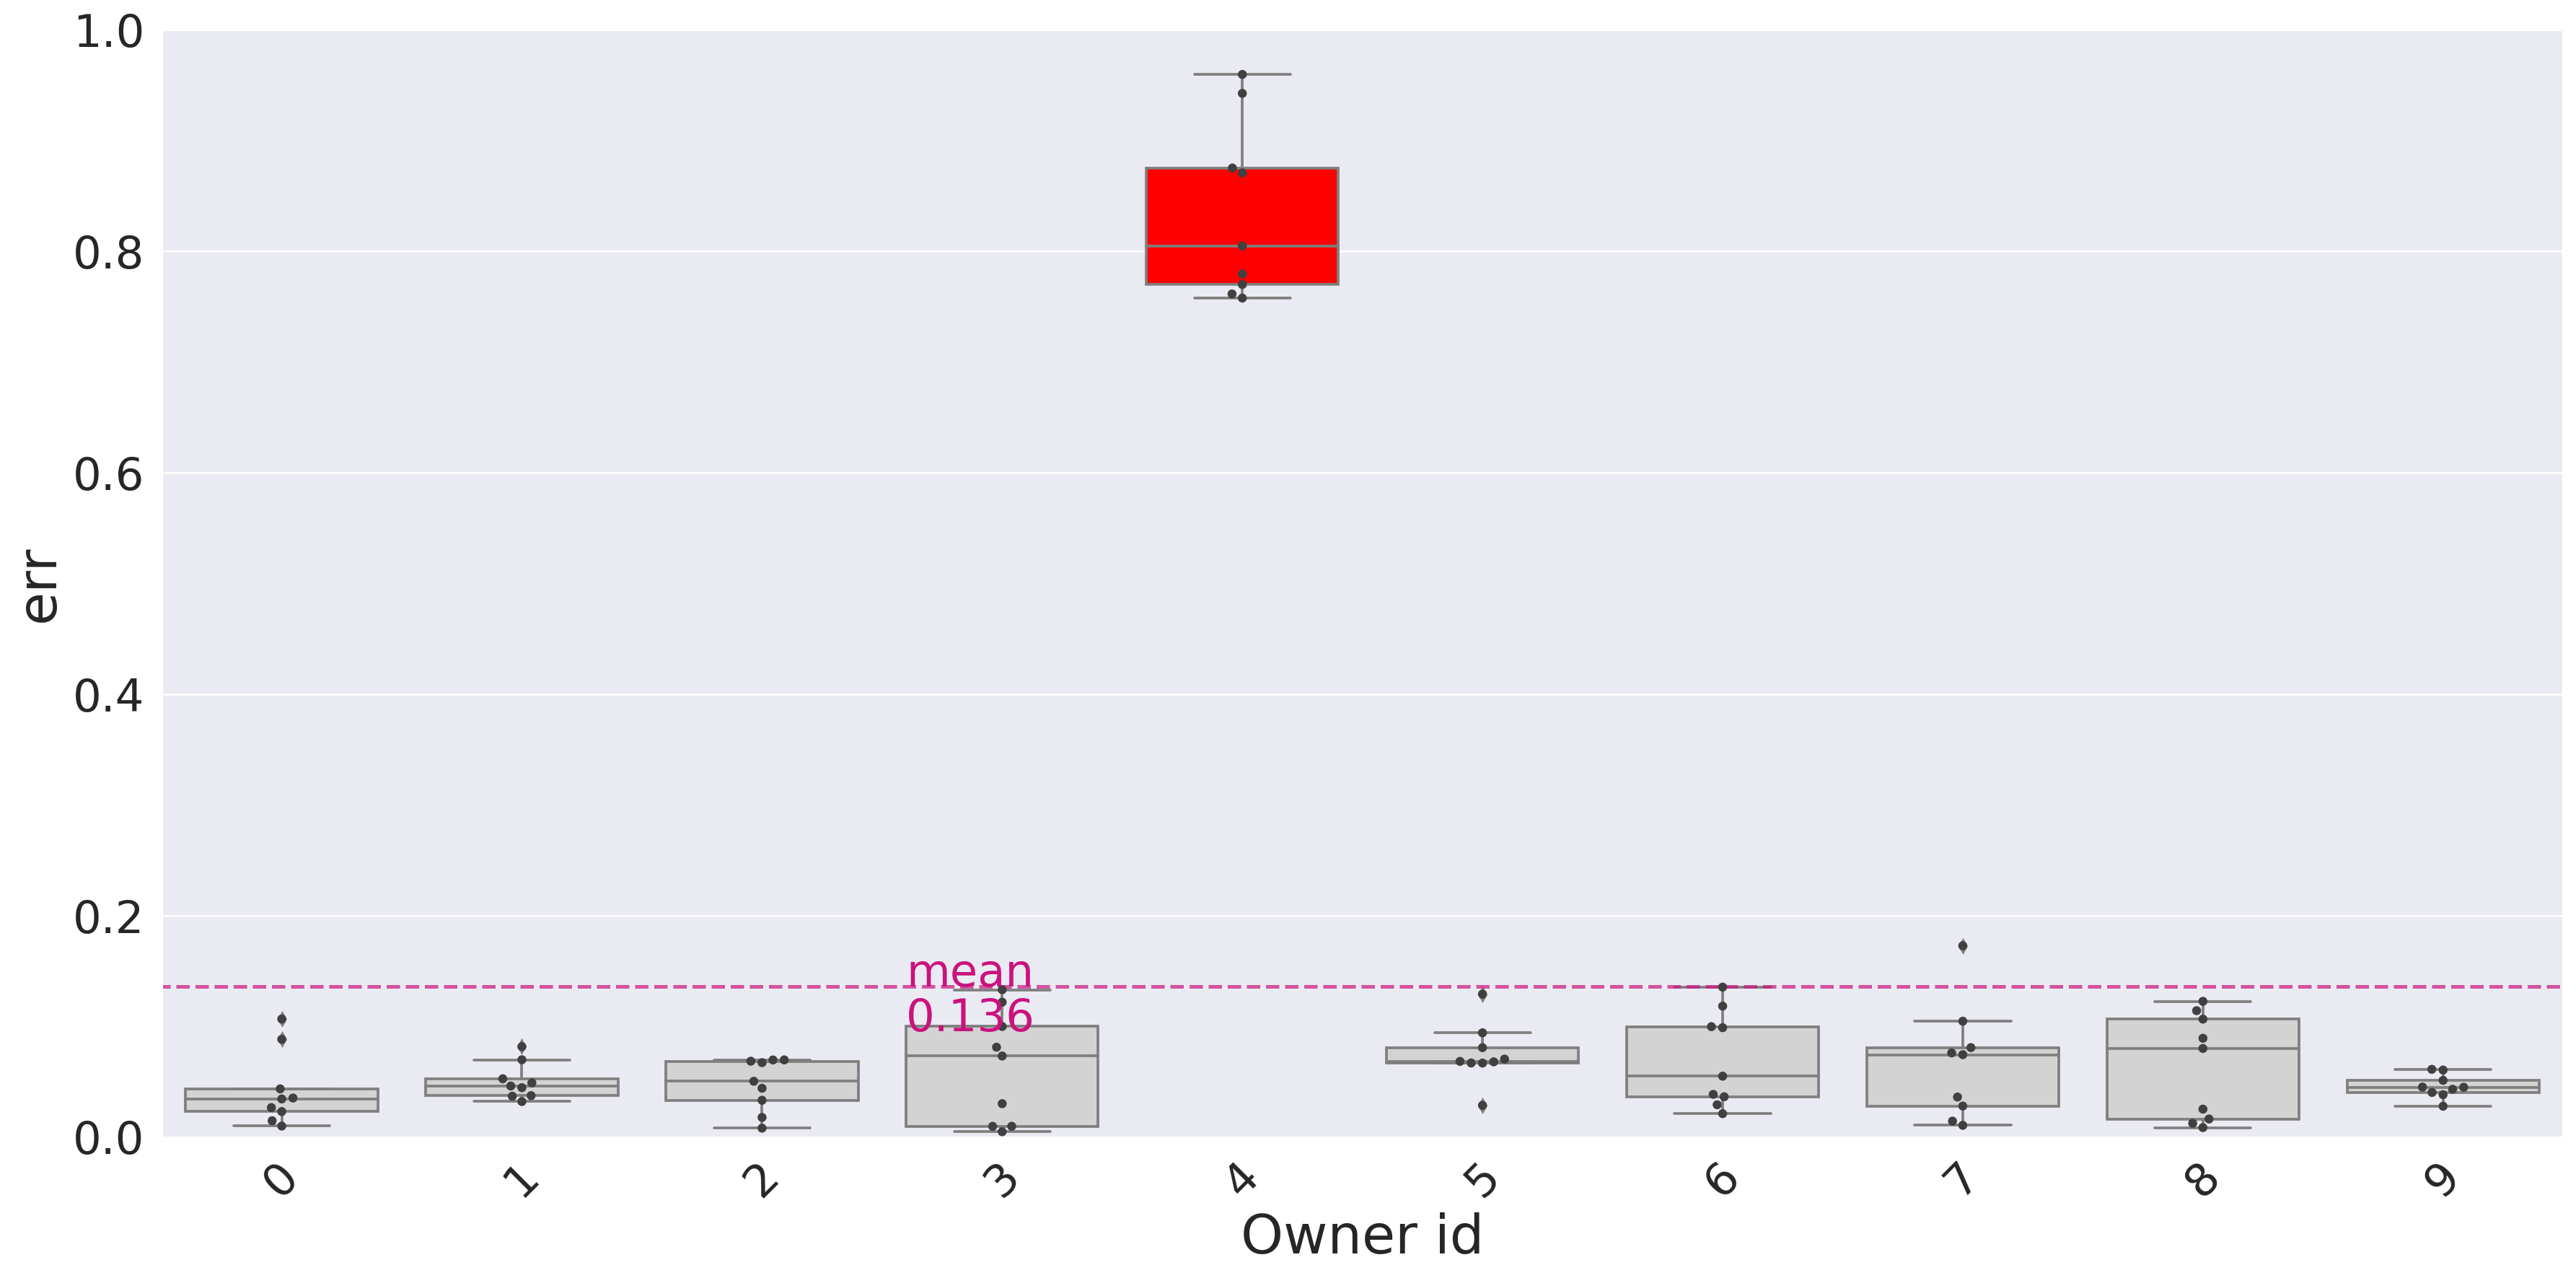

In [391]:
EER_distro_df = make_sys_error_data()
plot_sys_err_distro(EER_distro_df, '', save_file_name=f"Sys_Error.svg", boxplot_color="lightgrey", sys_err=True) 

Overall mean: 0.0659


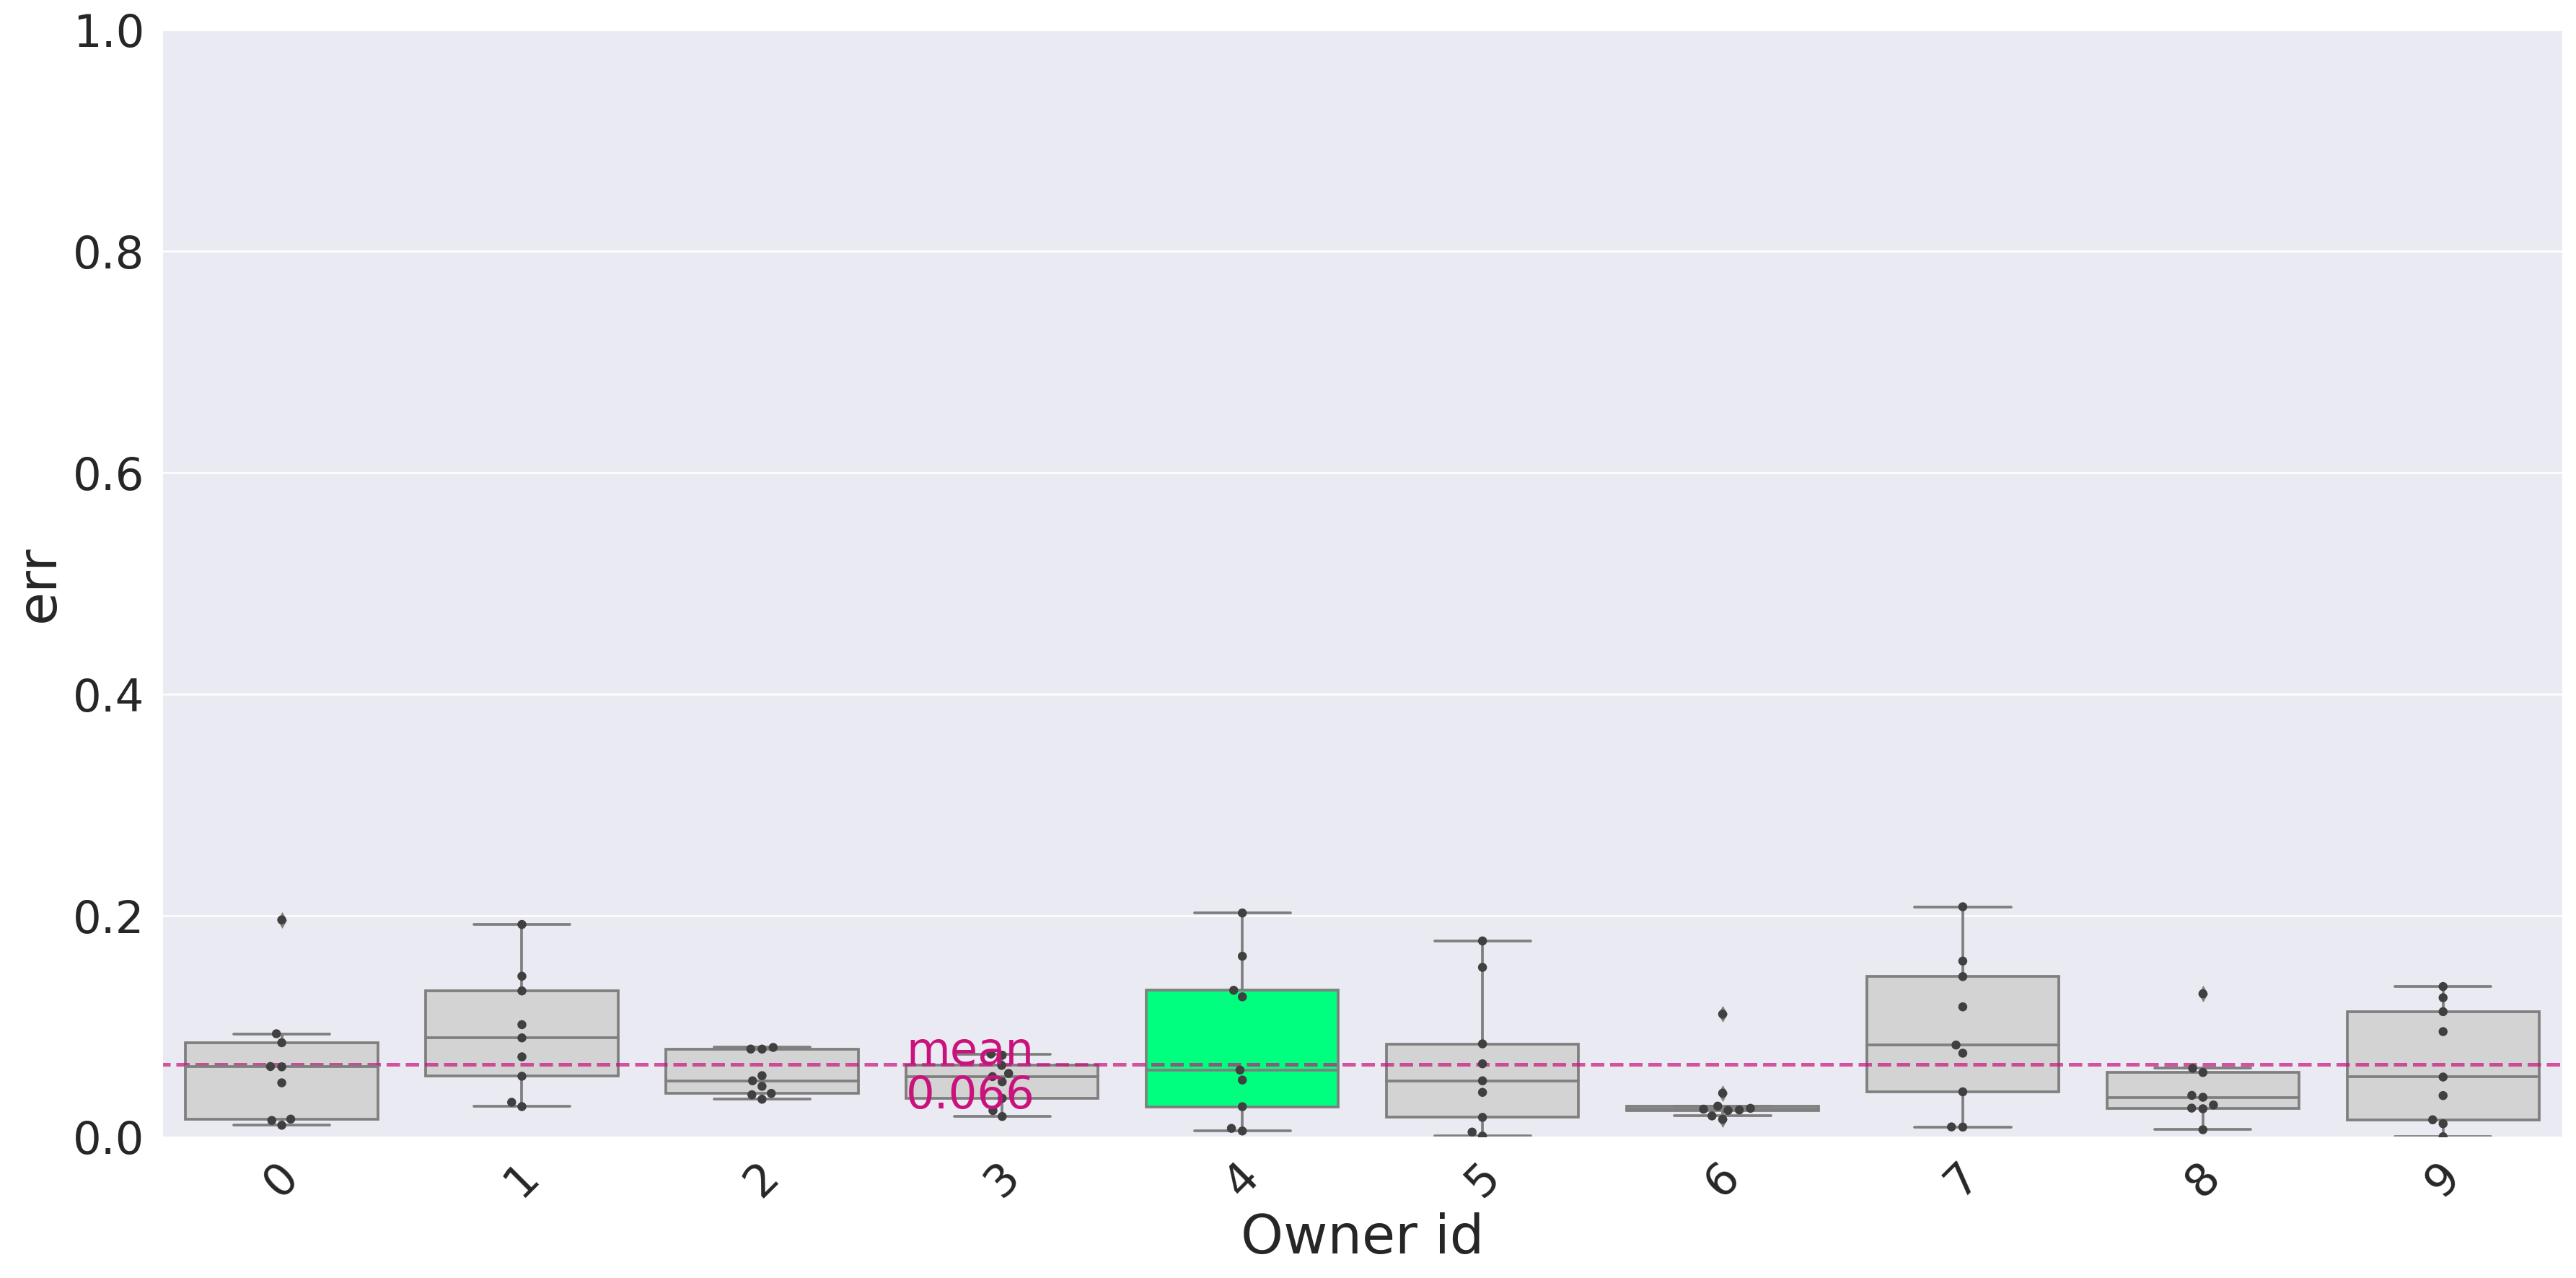

In [395]:
EER_distro_df = make_sys_error_data(sys_err=False)
plot_sys_err_distro(EER_distro_df, '', save_file_name=f"No_Sys_Error.svg", boxplot_color="lightgrey", sys_err=False)

In [390]:
a = np.random.normal(0.05, 0.02, 200)
print(a[a<0])
a=a[a>0]
print(a.shape)
print(a.max())
print(a.min())
print(a.mean())

[]
(200,)
0.10863442829841116
0.004390110866448978
0.050473162129480505


In [385]:
a

array([0.06579252, 0.05830976, 0.01608542, 0.01565746, 0.06954898,
       0.0841323 , 0.04483414, 0.08881961, 0.07243398, 0.05959916,
       0.03766438, 0.08269046, 0.012959  , 0.07125338, 0.03647556,
       0.0399303 , 0.03706062, 0.06163786, 0.03470885, 0.06479524,
       0.04233706, 0.07349469, 0.05210986, 0.04315495, 0.07704807,
       0.07368581, 0.05773289, 0.05359207, 0.05266443, 0.04207633,
       0.0315962 , 0.03160187, 0.06011102, 0.05038964, 0.0556507 ,
       0.04521152, 0.03796201, 0.09310008, 0.02765483, 0.04967507,
       0.02482893, 0.04262562, 0.06250145, 0.01239132, 0.06347492,
       0.05848412, 0.01894593, 0.06921261, 0.04274553, 0.05334083,
       0.05301339, 0.05554758, 0.04246059, 0.03994864, 0.05705127,
       0.10681405, 0.03481808, 0.06625881, 0.05977   , 0.04101408,
       0.04195909, 0.06248212, 0.06079374, 0.04674814, 0.05390832,
       0.03542755, 0.03890286, 0.06762871, 0.04878434, 0.05989875,
       0.03419171, 0.03829965, 0.07800144, 0.01473709, 0.04159